# Automatic nonuniform grid

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FAutoGrid.ipynb).

Here we demonstrate how to use the automatic nonuniform grid generation available in Tidy3D. We will show different possible ways to discretize the air-slot waveguide first introduced in [this reference](https://opg.optica.org/ol/abstract.cfm?uri=ol-29-11-1209).

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
from tidy3d.plugins import ModeSolver

[17:25:07] INFO     Using client version: 1.8.0                               ]8;id=472955;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=363127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#112\112]8;;\

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm
freq0 = td.C_0 / wavelength

# waveguide parameters
slot_width = 50 * nm
box_length = 300 * nm
box_height = 180 * nm

# materials
si_med = td.Medium(permittivity=3.48**2)
sub_med = td.Medium(permittivity=1.46**2)

# structures
box1 = td.Structure(
    geometry=td.Box(
        center=(0, -box_length / 2 - slot_width / 2, 0),
        size=(td.inf, box_length, box_height)),
    medium=si_med
)
box2 = td.Structure(
    geometry=td.Box(
        center=(0, box_length / 2 + slot_width / 2, 0),
        size=(td.inf, box_length, box_height)),
    medium=si_med
)

# boundaries
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

Define a helper function to show us the various grids as we go along this exmaple.

In [3]:
# Plot simulation and overlay grid in the yz and xy planes
def plot_sim_grid(sim):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sim.plot(x=0, ax=ax[0])
    sim.plot_grid(x=0, ax=ax[0], lw=0.4, colors='r')
    ax[0].set_xlim(-0.6, 0.6)
    ax[0].set_ylim(-0.4, 0.4)
    sim.plot(z=0, ax=ax[1])
    sim.plot_grid(z=0, ax=ax[1], lw=0.4, colors='r')
    ax[1].set_xlim(-0.6, 0.6)
    ax[1].set_ylim(-0.4, 0.4)
    print(f"Total number of grid points (millions): {sim.num_cells / 1e6:1.2}")
    
    return ax

## Uniform grid

The most standard way to define a simulation is to use a constant grid size in each of the three directions. This can be achieved simply using `td.GridSpec.uniform(dl=...)` as shown below.

[17:25:08] WARNING  No sources in simulation.                               ]8;id=41784;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=457365;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 8.3


<Figure size 864x432 with 2 Axes>

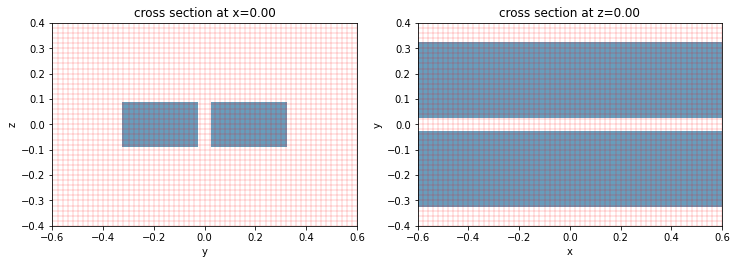

In [4]:
sim_uniform = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.uniform(dl=20*nm),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

plot_sim_grid(sim_uniform);

## Automatic nonuniform grid

By default, Tidy3D uses a more advanced meshing, using an algorithm to automatically define a nonuniform grid in all three directions. The resolution of this grid is specified using the desired minimum steps per wavelength in each material (`min_steps_per_wvl = 10` by default). This specification therefore requires a target wavelength, which can be either provided directly to `grid_spec`, or inferred from any sources present in the simulation. The two simulations below will have the same grid.

           WARNING  No sources in simulation.                               ]8;id=730669;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=18746;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

           INFO     Auto meshing using wavelength 1.5500 defined from        ]8;id=90520;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=298956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#510\510]8;;\
                    sources.                                                                 

Total number of grid points (millions): 0.53


<Figure size 864x432 with 2 Axes>

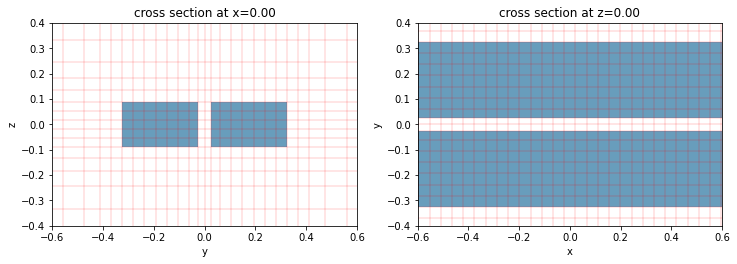

In [5]:
# provide wavelength directly
sim_nonuniform_10 = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(wavelength=wavelength),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

# no grid_spec defined; using default with wavelength taken from source
source = td.ModeSource(
    center=(-2, 0, 0),
    size=(0, 2, 2),
    mode_index=0,
    direction="+",
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10)
)
sim_nonuniform_10 = td.Simulation(
    size=[5, 3, 3],
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12,
    sources=[source],
)

ax = plot_sim_grid(sim_nonuniform_10)

The default grid is somewhat coarse, but it is often good for initial simulations. We can easily refine it by requiring a higher number of steps per wavelength:

           WARNING  No sources in simulation.                               ]8;id=575956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=963657;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 2.3


<Figure size 864x432 with 2 Axes>

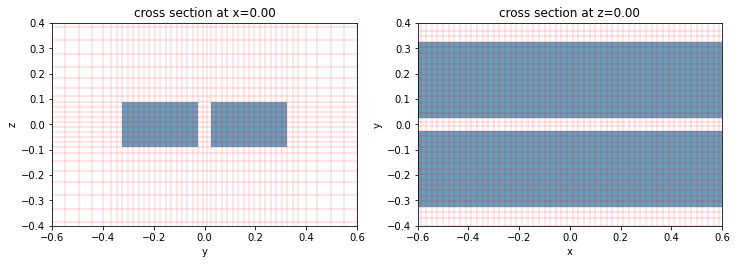

In [6]:
sim_nonuniform_20 = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)
ax = plot_sim_grid(sim_nonuniform_20)

Notice how the automatic grid conforms to the structures in the simulation, and the grid steps are high in the high-index regions. 

### Lower bound of grid size
Sometimes the grid size in the automatically generated mesh is too small. A lower bound `global_min_dl` can be set to increase the minimal grid size. Note that the bound is soft, meaning that the actual grid size might be slightly smaller.

The minimal step size along y-direction in the previous setup is,

In [7]:
print(f"Minimal grid size along y-direction = {min(sim_nonuniform_20.grid.sizes.y)*1e3:1.2f}nm")

Minimal grid size along y-direction = 16.67nm


Now let's set a lower bound of 25nm.

[17:25:09] WARNING  No sources in simulation.                               ]8;id=331733;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=445001;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 1.9
Minimal grid size along y-direction = 24.57nm


<Figure size 864x432 with 2 Axes>

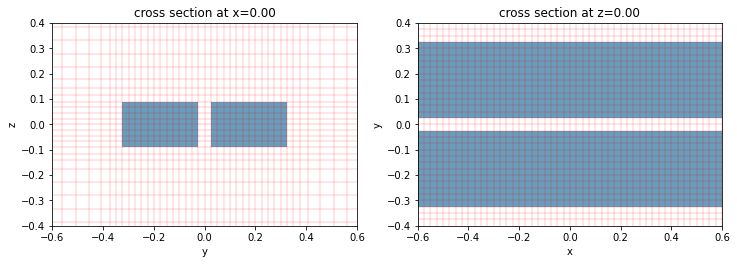

In [8]:
sim_nonuniform_20 = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        global_min_dl=25*nm,
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)
ax = plot_sim_grid(sim_nonuniform_20)
print(f"Minimal grid size along y-direction = {min(sim_nonuniform_20.grid.sizes.y)*1e3:1.2f}nm")

The actual minimal grid size along y-direction is 24.57nm, greater than 16.67nm when `global_min_dl` is not set.

### Mesh override structures
For this particular problem, we may want to do a final refinement around the slot, where we expect the fields to be strongest. This can be achieved by adding `override_structures` to the simulation `grid_spec`.

`override_structures` is a list of Tidy3D structures each with an arbitrary geometry which are used exclusively for the meshing, added on top of any physical simulation structures.

There are two types of Tidy3D structures that can be added the `override_structures` list. The first type defines a fictitious medium inside the override structure so that the grid size is decided by the minimum steps per wavelength in the medium; The second type is more straightforward: one can directly define the grid size along each axis inside the override structures.

#### Override Structure -- option 1
The first type is identical to the [Structure](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Structure.html) object that consists of a [Geometry](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.components.geometry.Geometry.html) and a [Medium](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.components.medium.AbstractMedium.html). The grid step in the override_structure region is decided by the minimum steps per wavelength in this `medium`.

           WARNING  No sources in simulation.                               ]8;id=454597;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=689628;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 4.0


<Figure size 864x432 with 2 Axes>

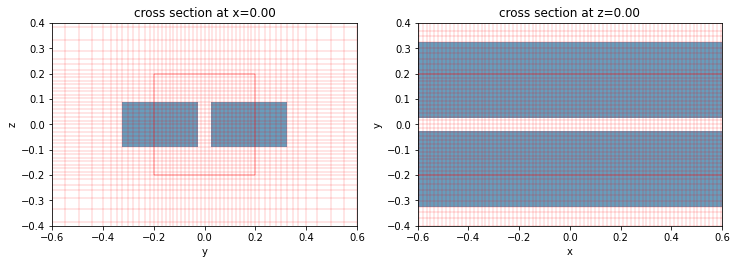

In [9]:
# Define a "dummy" box with refractive index 5 around the central location of the waveguide
refine_box = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, 0.4, 0.4)),
    medium=td.Medium(permittivity=5 ** 2),
)

# Use the box as a grid refinement structure
sim_nonuniform_20_refine = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        override_structures=[refine_box],
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_20_refine)

Note that the override region is highlighted in the grid plotting. Now this looks pretty good - the grid size of the points around the slot region is `1550 / 20 / 5 = 15.5` nanometers, while overall the simulation has twice fewer total number of grid points (`4.0M`) compared to the simulation with a uniform mesh step of `20` nanometers (`8.3M`). One thing to note, however, is that the override structure made the grid along the x-dimension small, which may not be necessary. To avoid this, we can change that structure to have `size = 0` along that dimension. This would force the non-uniform grid to place a grid boundary at the `center` of the override structure along `x`, but apart from that it will not refine the grid step along `x`.

           WARNING  No sources in simulation.                               ]8;id=740524;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=487158;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 3.0


<Figure size 864x432 with 2 Axes>

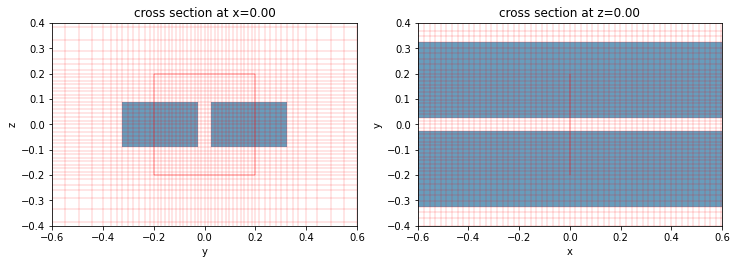

In [10]:
# Redefine the box with size 0 along x
refine_box = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(0, 0.4, 0.4)),
    medium=td.Medium(permittivity=5 ** 2),
)

# Use the box as a grid refinement structure
sim_nonuniform_20_refine = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        override_structures=[refine_box],
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_20_refine)

#### Override Structure -- option 2
The second type is the [MeshOverrideStructure](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.MeshOverrideStructure.html) object that consists of a [Geometry](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.components.geometry.Geometry.html), and a tuple `dl` specifying the grid sizes along x,y,z directions. We can override the grid sizes just along a few selected directions by setting the value to be `None` in the `dl` tuple along the other directions. E.g. if we only plan to refine the grid size along x-direction with grid size 0.01 micron, we can apply `dl=(0.01, None, None)`. In the following, we override the grid size along `y` and `z` to be 15.5nm.

           WARNING  No sources in simulation.                               ]8;id=975360;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=475896;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 2.9


<Figure size 864x432 with 2 Axes>

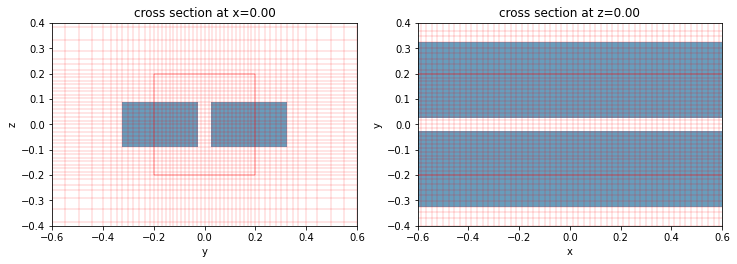

In [11]:
refine_box = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, 0.4, 0.4)),
    dl=[None, 15.5*nm, 15.5*nm],
)

# Use the box as a grid refinement structure
sim_nonuniform_20_refine = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        override_structures=[refine_box],
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_20_refine)

Just for fun, we can also have a look at the modes of this structure.

[17:25:11] WARNING  No sources in simulation.                               ]8;id=724232;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=856345;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

<Figure size 864x1008 with 12 Axes>

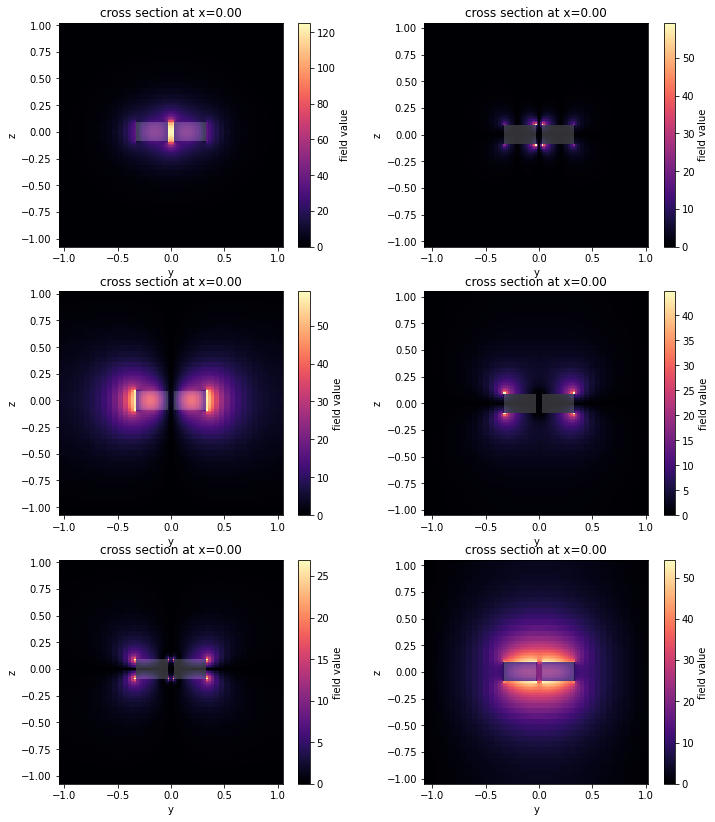

In [12]:
num_modes = 3
plane = td.Box(center=(0, 0, 0), size=(0, 2, 2))
mode_spec=td.ModeSpec(num_modes=num_modes)
ms = ModeSolver(simulation=sim_nonuniform_20_refine, plane=plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()
fig, axs = plt.subplots(num_modes, 2, figsize=(12, 14))
for mode_ind in range(num_modes):
    ms.plot_field("Ey", "abs", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0], robust=False)
    ms.plot_field("Ez", "abs", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1], robust=False)

#### Mesh override with coarser grid size
Sometimes, instead of refinement, we want to override a region with a coarser mesh. This can be achieved by setting `enforce=True` in [MeshOverrideStructure](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.MeshOverrideStructure.html).

First, let's see the default behavior where `enforce=False` so that the override structure with coarser mesh will be ignored unless it fully covers the structure of fine mesh. In the following example, we try to override the mesh along x-direction be to 40nm.

[17:25:12] WARNING  No sources in simulation.                               ]8;id=944889;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=240190;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 2.9
Minimal grid size along x-direction = 22.22nm


<Figure size 864x432 with 2 Axes>

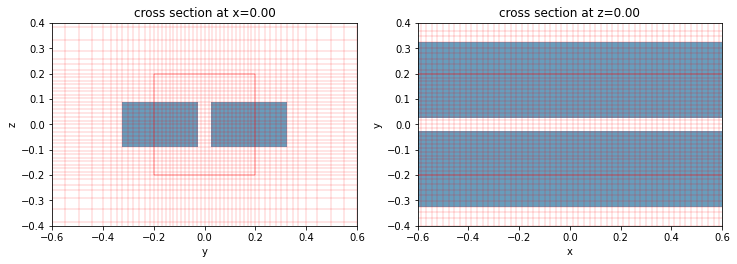

In [13]:
refine_box = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, 0.4, 0.4)),
    dl=[50*nm, 15.5*nm, 15.5*nm],
)

# Use the box as a grid refinement structure
sim_nonuniform_20_coarser = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        override_structures=[refine_box],
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_20_coarser)
print(f"Minimal grid size along x-direction = {min(sim_nonuniform_20_coarser.grid.sizes.x)*1e3:1.2f}nm")

The minimal grid size along x-direction is still 22nm, so the `override_structures` doesn't take effect. This is because, by default, the meshing chooses the step size based on the highest-index structure (real or override) at any given cross-section. However, this behavior can be overridden if we set `enforce=True` in an `MeshOverrideStructure`, in which case other structures are ignored.

[17:25:13] WARNING  No sources in simulation.                               ]8;id=214076;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=854372;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

Total number of grid points (millions): 1.4
Minimal grid size along x-direction = 40.00nm


<Figure size 864x432 with 2 Axes>

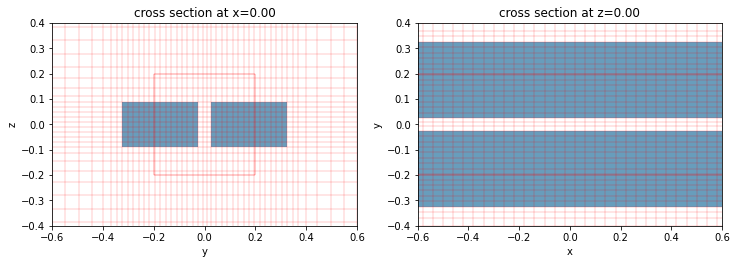

In [14]:
refine_box = td.MeshOverrideStructure(
    geometry=td.Box(center=(0, 0, 0), size=(td.inf, 0.4, 0.4)),
    dl=[40*nm, None, None],
    enforce=True,
)

# Use the box as a grid refinement structure
sim_nonuniform_20_coarser = td.Simulation(
    size=[5, 3, 3],
    grid_spec=td.GridSpec.auto(
        wavelength=wavelength,
        min_steps_per_wvl=20,
        override_structures=[refine_box],
    ),
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_20_coarser)
print(f"Minimal grid size along x-direction = {min(sim_nonuniform_20_coarser.grid.sizes.x)*1e3:1.2f}nm")

Now the minimal grid size along x-direction is target 40nm. When multiple override structures with `enforce=True` overlap, the grid size in the intersection region is decided by the last such structure in the list.

## Combination of uniform and nonuiform grid

Finally, we note that Tidy3D allows another easy way to handle the `x` direction in our example, namely applying different grid specifications along each of the three simulation directions. For example, we can set a fixed grid size of `40nm` along the propagation direction, where we expect the field dependence to be smooth, while still using the refined nonuniform mesh in the other two directions. This achieves the same effect as in the plot above.

           WARNING  No sources in simulation.                               ]8;id=643672;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=799352;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#456\456]8;;\

           WARNING  Override structures take no effect along x-axis. If      ]8;id=398762;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=350712;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#519\519]8;;\
                    intending to apply override structures to this axis, use                 
                    'AutoGrid'.                                                              

Total number of grid points (millions): 1.4


<Figure size 864x432 with 2 Axes>

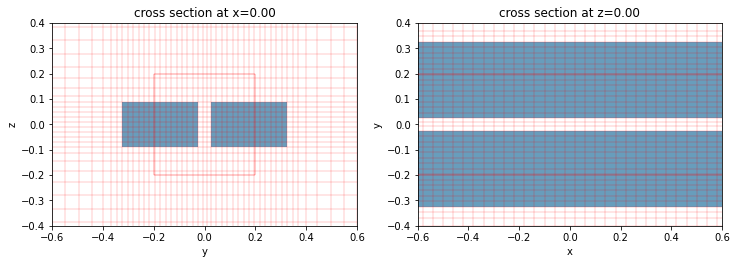

In [15]:
grid_spec = td.GridSpec(
    grid_x = td.UniformGrid(dl=0.04),
    grid_y = td.AutoGrid(min_steps_per_wvl=20),
    grid_z = td.AutoGrid(min_steps_per_wvl=20),
    wavelength=wavelength,
    override_structures=[refine_box]
)

sim_nonuniform_yz_uniform_x = td.Simulation(
    size=[5, 3, 3],
    grid_spec=grid_spec,
    medium=sub_med,
    structures=[box1, box2],
    boundary_spec=boundary_spec,
    run_time=1e-12
)

ax = plot_sim_grid(sim_nonuniform_yz_uniform_x)